In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

In [2]:
data = pd.read_csv(r"C:\Users\himan\Desktop\7th GAN\DATASETS\MumbaiCovidcsv.csv")
data

,From Date,PM2.5,NO2,Ozone,RH,WS,WD,SR,BP,RF,AT
0,01-01-2019 00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01-01-2019 01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01-01-2019 02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01-01-2019 03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01-01-2019 04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43819,31-12-2023 19:00,36.453333,30.333333,29.490000,77.9,0.1450,260.7450,NaN,1011.2050,NaN,26.6525
43820,31-12-2023 20:00,41.647500,30.370000,40.027500,77.9,0.1350,262.8250,NaN,1011.9075,NaN,25.5975
43821,31-12-2023 21:00,58.050000,30.092500,50.552500,77.9,0.1350,264.1175,NaN,1012.3650,NaN,24.8025
43822,31-12-2023 22:00,NaN,30.623333,49.326667,77.9,0.1400,263.9175,NaN,1012.6775,NaN,24.0700


In [3]:
data = data.drop(columns=[ 'From Date'])

In [4]:
# Replaceing NaN values with 0
data.fillna(0, inplace=True)

In [5]:
#  dataset has columns for features and a target variable

feature_columns = ['PM2.5'	,'NO2'	,'Ozone'	,'RH'	,'WS'	,'WD'	,'SR'	,'BP'	,'RF'	,'AT']
target_column = 'PM2.5'

In [6]:
# Splitting the dataset into features and target variable
X = data[feature_columns].values
y = data[target_column].values

In [7]:
# Normalizing the feature values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
# sliding window parameters
window_size = 5  # Number of past time steps considered
output_size = 10  # Number of steps ahead used to predict pollutant concentration

In [9]:
# Create 3D dataset using sliding window technique
def create_dataset(X, y, window_size, output_size):
    X_windowed = []
    y_windowed = []
    for i in range(len(X) - window_size - output_size + 1):
        X_windowed.append(X[i:i+window_size])
        y_windowed.append(y[i+window_size:i+window_size+output_size])
    return np.array(X_windowed), np.array(y_windowed)

X_windowed, y_windowed = create_dataset(X_scaled, y, window_size, output_size)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

In [11]:
# Build the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(output_size))  # Output layer with 'output_size' neurons for multi-step ahead prediction
model.compile(optimizer='adam', loss='mse')

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100

1096/1096 [==============================] - 32s 17ms/step - loss: 1225.1288 - val_loss: 790.3452
Epoch 2/100
1096/1096 [==============================] - 17s 16ms/step - loss: 636.5317 - val_loss: 667.9302
Epoch 3/100
1096/1096 [==============================] - 17s 16ms/step - loss: 572.2263 - val_loss: 625.7022
Epoch 4/100
1096/1096 [==============================] - 16s 14ms/step - loss: 546.1813 - val_loss: 598.6023
Epoch 5/100
1096/1096 [==============================] - 18s 16ms/step - loss: 529.7447 - val_loss: 585.1342
Epoch 6/100
1096/1096 [==============================] - 18s 16ms/step - loss: 518.4678 - val_loss: 576.9022
Epoch 7/100
1096/1096 [==============================] - 20s 19ms/step - loss: 510.2382 - val_loss: 573.6885
Epoch 8/100
1096/1096 [==============================] - 20s 18ms/step - loss: 504.3954 - val_loss: 565.1812
Epoch 9/100
1096/1096 [==============================] - 23s 21ms/step - loss: 499.6435 - val_loss: 571.2811
Epoch 10/100
1096

In [13]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

274/274 [==============================] - 2s 6ms/step - loss: 476.7623
Test Loss: 476.76226806640625
274/274 [==============================] - 5s 6ms/step


In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Calculate Fraction of predictions with a factor of 2 (FAC2)
def fac2(y_true, y_pred):
    within_factor = np.abs(y_true / y_pred) <= 2
    return np.mean(within_factor)

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Correlation Coefficient (r)
r = np.corrcoef(np.ravel(y_test), np.ravel(predictions))[0, 1]

# Calculate Mean Gross Error (MGE)
mge = np.mean(np.abs(y_test - predictions))

# Calculate Mean Bias (MB)
mb = np.mean(y_test - predictions)

# Calculate Coefficient of Efficiency (COE)
coe = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

# Calculate Coefficient of Determination (R2 score)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f'Fraction of predictions with a factor of 2 (FAC2): {fac2(y_test, predictions)}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Correlation Coefficient (r): {r}')
print(f'Mean Gross Error (MGE): {mge}')
print(f'Mean Bias (MB): {mb}')
print(f'Coefficient of Efficiency (COE): {coe}')
print(f'Coefficient of Determination (R2 score): {r2}')

Fraction of predictions with a factor of 2 (FAC2): 0.9289089249029902
Root Mean Square Error (RMSE): 21.83488822777512
Correlation Coefficient (r): 0.8414170267351606
Mean Gross Error (MGE): 12.620683977817903
Mean Bias (MB): 0.5117545097572128
Coefficient of Efficiency (COE): 0.707196144757704
Coefficient of Determination (R2 score): 0.7058229827825718


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats


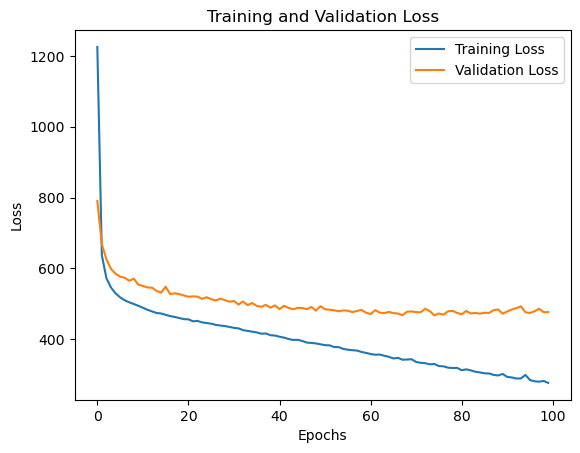

In [16]:

# Plot training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


C:\Users\himan\AppData\Local\Temp\ipykernel_9724\1899136162.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


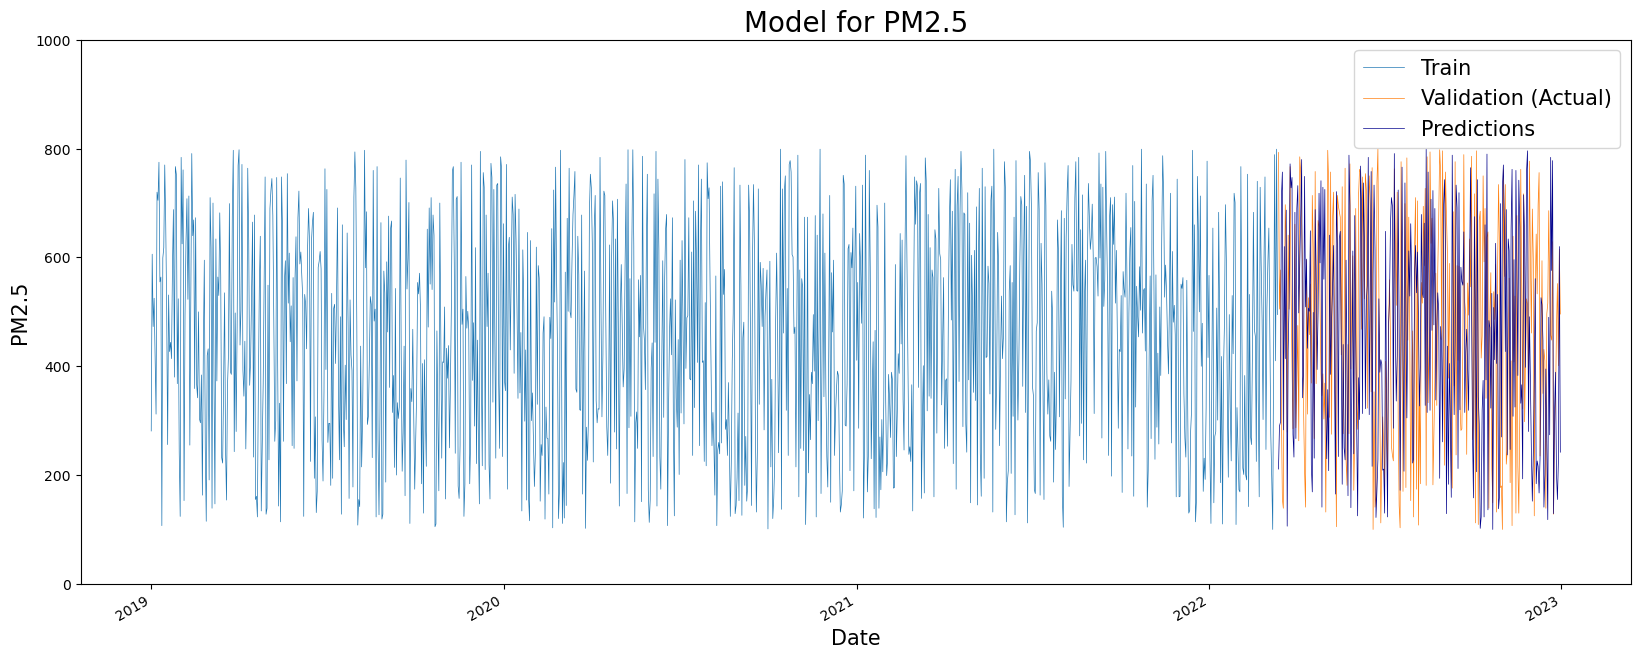

In [17]:
import pandas as pd
import matplotlib.dates as mdates

# Example DataFrame with dates from 2019 to 2024
date_range = pd.date_range(start='1/1/2019', end='31/12/2022')
df_date = pd.DataFrame({
    'Date': date_range,
    'PM2.5': np.random.randint(100, 800, size=len(date_range))
})
df_date.set_index('Date', inplace=True)

# Define the training data length
training_data_len = int(len(df_date) * 0.8)

# Split the data
train = df_date[:training_data_len]
valid = df_date[training_data_len:]

# Example predictions with the correct shape
predictions = np.random.randint(100, 800, size=len(valid))

# Add predictions to the validation set
valid["Predictions"] = predictions

# Plotting
plt.figure(figsize=(20,8))
plt.title("Model for PM2.5", fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("PM2.5", fontsize=15)  # Updated y-axis label

# Plot with reduced line thickness
plt.plot(train.index, train['PM2.5'], label='Train', linewidth=0.5)
plt.plot(valid.index, valid['PM2.5'], label='Validation (Actual)', linewidth=0.5)
plt.plot(valid.index, valid["Predictions"], label='Predictions', linewidth=0.5, color='darkblue')

# Format the x-axis to show only the year
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Set y-axis limits
plt.ylim(0, 1000)

plt.legend(fontsize=15)
plt.show()

# END**